In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import random
import typing as T
import json
import ctypes
from multiprocessing import Pool, cpu_count, Array
from collections import defaultdict

import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.rdMolDescriptors import CalcMolFormula, CalcExactMolWt

import massspecgym.utils as utils

In [3]:
random.seed(0)

tqdm.pandas()

# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Read sets of molecules

In [12]:
df_1M = pd.read_csv(utils.hugging_face_download('molecules/MassSpecGym_retrieval_molecules_1M.tsv'), sep='\t')
df_1M.shape, df_1M.columns

MassSpecGym_retrieval_molecules_1M.tsv:   0%|          | 0.00/291M [00:00<?, ?B/s]

((1032456, 5),
 Index(['smiles', 'inchi_key_2D', 'inchi', 'formula', 'mass'], dtype='object'))

In [5]:
df_4M = pd.read_csv(utils.hugging_face_download('molecules/MassSpecGym_retrieval_molecules_4M.tsv'), sep='\t')
df_4M.shape, df_4M.columns

((4175091, 4),
 Index(['smiles', 'inchikey', 'formula', 'mass'], dtype='object'))

In [6]:
df_pubchem_118M = pd.read_csv('MassSpecGym_retrieval_molecules_pubchem_118M.tsv', sep='\t')
# df_pubchem_118M = pd.read_csv(utils.hugging_face_download('molecules/MassSpecGym_retrieval_molecules_pubchem_118M.tsv'), sep='\t')
# df_pubchem_118M.shape, df_pubchem_118M.columns

## Read spectral library

In [7]:
df_massspecgym = pd.read_csv(utils.hugging_face_download('MassSpecGym.tsv'), sep='\t')
smiles = df_massspecgym['smiles']
smiles = smiles.drop_duplicates()
len(df_massspecgym), len(smiles)

/tmp/ipykernel_234873/2379360413.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_massspecgym = pd.read_csv(utils.hugging_face_download('MassSpecGym.tsv'), sep='\t')


(414049, 33597)

## Generate retrieval candidates from molecule sets for the spectral library

In [8]:
def dedup(seq):
    """Deduplicate list while preserving order (https://stackoverflow.com/a/480227)"""
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]


def get_candidates(
        query_smiles: T.Iterable[str],
        df: pd.DataFrame,
        cand_type: str = 'formula',
        max_cands: int = 256,
        candidates: T.Optional[T.Mapping] = None,
        check_query_in_cands: bool = False
    ) -> T.Mapping:
    """For query SMILES strings, find similar SMILES from the dataframe"""
    if candidates is None:
        candidates = defaultdict(list)
    if check_query_in_cands:
        n_queries_absent_in_db = 0

    for s in tqdm(query_smiles):

        # Add query SMILES as on of the candidates
        if not candidates[s]:
            candidates[s].append(s)

        # Query is already saturated with candidantes
        if len(candidates[s]) == max_cands:
            continue

        # Find new candidates for the query
        if cand_type == 'formula':
            formula = CalcMolFormula(Chem.MolFromSmiles(s))
            new_cands = df['smiles'][df['formula'] == formula].tolist()
        elif cand_type == 'mass':
            mass = CalcExactMolWt(Chem.MolFromSmiles(s))
            mass_eps = mass * 1e-6 * 10  # 10 ppm
            new_cands = df['smiles'][(df['weight'] - mass).abs() < mass_eps].tolist()
        else:
            raise ValueError(f'Unknown candidates type {cand_type}.')

        # Shuffle new candidates to reach a random sample if prunned in the next step
        random.shuffle(new_cands)

        # Check is query SMILES is found in the corresponding candidate list
        if check_query_in_cands and s not in candidates[s]:
            n_queries_absent_in_db += 1

        # Add new candidates until maximum number is reached
        candidates[s].extend(new_cands)
        candidates[s] = dedup(candidates[s])[:max_cands]
        
    if check_query_in_cands:
        print('Number of queries absent in the database:', n_queries_absent_in_db)
    return candidates

In [9]:
def init(shared_smiles, shared_formula, shared_mass):
    global df_smiles, df_formula, df_mass
    df_smiles = shared_smiles
    df_formula = shared_formula
    df_mass = shared_mass

def get_candidates_single(args):
    index, smiles, cand_type, max_cands = args
    candidates_single = []

    # Log the process ID
    # logging.info(f'Process ID: {os.getpid()} handling SMILES: {smiles}')

    # Add query SMILES as one of the candidates
    if not candidates_single:
        candidates_single.append(smiles)

    # Query is already saturated with candidates
    if len(candidates_single) == max_cands:
        return candidates_single

    # Find new candidates for the query
    if cand_type == 'formula':
        formula = CalcMolFormula(Chem.MolFromSmiles(smiles))
        new_cands = [df_smiles[i] for i in range(len(df_smiles)) if df_formula[i] == formula]
    elif cand_type == 'mass':
        mass = CalcExactMolWt(Chem.MolFromSmiles(smiles))
        mass_eps = mass * 1e-6 * 10  # 10 ppm
        new_cands = [df_smiles[i] for i in range(len(df_smiles)) if abs(df_mass[i] - mass) < mass_eps]
    else:
        raise ValueError(f'Unknown candidates type {cand_type}.')

    # Shuffle new candidates to reach a random sample if pruned in the next step
    random.shuffle(new_cands)

    # Add new candidates until the maximum number is reached
    candidates_single.extend(new_cands)
    candidates_single = dedup(candidates_single)[:max_cands]

    return candidates_single

def get_candidates_parallel(
        query_smiles: T.Iterable[str],
        df: pd.DataFrame,
        cand_type: str = 'formula',
        max_cands: int = 256,
        df_candidates: T.Optional[pd.DataFrame] = None,
        max_workers: int = cpu_count() - 2
    ) -> pd.DataFrame:
    """For query SMILES strings, find similar SMILES from the dataframe in parallel"""
    logging.info('Starting get_candidates_parallel')

    if df_candidates is None:
        df_candidates = pd.DataFrame({'smiles': query_smiles, 'cands': [[] for _ in query_smiles]})
        logging.info('Initialized df_candidates with empty candidate lists')

    # Convert DataFrame columns to numpy arrays
    df_smiles_array = df['smiles'].to_numpy()
    df_formula_array = df['formula'].fillna('').to_numpy()
    df_mass_array = df['mass'].to_numpy()

    # Create shared arrays not to copy df for each process (critical in the case of whole PubChem)
    shared_smiles = Array(ctypes.c_wchar_p, df_smiles_array, lock=False)
    shared_formula = Array(ctypes.c_wchar_p, df_formula_array, lock=False)
    shared_mass = Array(ctypes.c_double, df_mass_array, lock=False)

    logging.info(f'Setting up shared arrays with {max_workers} workers')
    
    with Pool(processes=max_workers, initializer=init, initargs=(shared_smiles, shared_formula, shared_mass)) as pool:
        args = [(index, row['smiles'], cand_type, max_cands) for index, row in df_candidates.iterrows()]
        
        # Use tqdm to show the progress bar
        results = []
        for result in tqdm(pool.imap(get_candidates_single, args), total=len(args)):
            results.append(result)
        
        df_candidates['cands'] = results
        logging.info('Finished multiprocessing pool')

    logging.info('Completed get_candidates_parallel')
    return df_candidates

2024-05-29 17:22:58,083 - INFO - Starting get_candidates_parallel
2024-05-29 17:22:58,099 - INFO - Initialized df_candidates with empty candidate lists
2024-05-29 17:23:00,375 - INFO - Setting up shared arrays with 32 workers
100%|██████████| 33597/33597 [01:37<00:00, 345.42it/s]
2024-05-29 17:25:00,135 - INFO - Finished multiprocessing pool
2024-05-29 17:25:02,124 - INFO - Completed get_candidates_parallel


<Axes: >

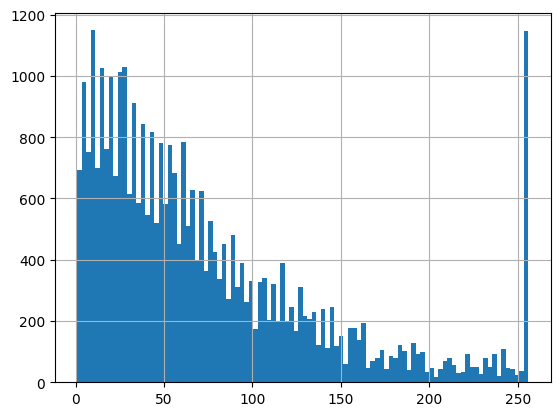

In [13]:
candidates = get_candidates_parallel(smiles, df_1M, cand_type='mass', max_workers=32)
candidates['cands'].apply(len).hist(bins=100)

2024-05-29 17:25:18,727 - INFO - Starting get_candidates_parallel
2024-05-29 17:25:27,745 - INFO - Setting up shared arrays with 126 workers
100%|██████████| 33597/33597 [03:34<00:00, 156.64it/s]
2024-05-29 17:30:32,873 - INFO - Finished multiprocessing pool
2024-05-29 17:30:36,032 - INFO - Completed get_candidates_parallel


<Axes: >

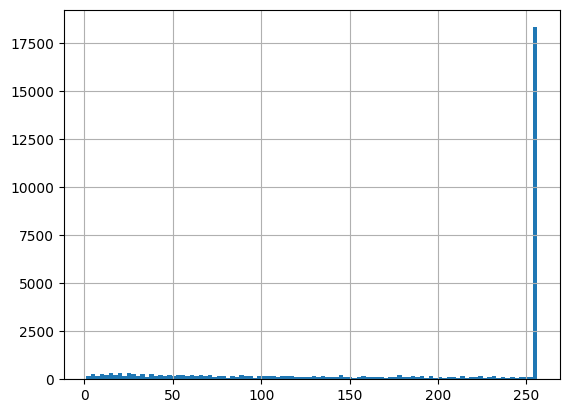

In [14]:
candidates = get_candidates_parallel(smiles, df_4M, cand_type='mass', df_candidates=candidates)
candidates['cands'].apply(len).hist(bins=100)

In [15]:
candidates.to_pickle('cands_4M_mass.pkl')
# candidates = pd.read_pickle('cands_4M_mass.pkl')

2024-05-29 17:36:26,877 - INFO - Starting get_candidates_parallel
2024-05-29 17:49:58,699 - INFO - Setting up shared arrays with 126 workers
100%|██████████| 33597/33597 [2:42:07<00:00,  3.45it/s]  
2024-05-29 20:37:41,651 - INFO - Finished multiprocessing pool
2024-05-29 20:37:53,865 - INFO - Completed get_candidates_parallel


<Axes: >

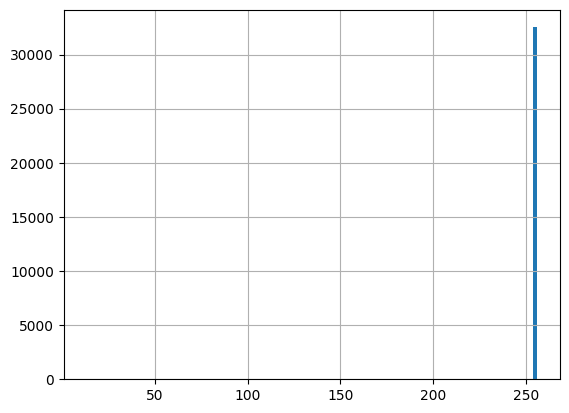

In [16]:
candidates = get_candidates_parallel(smiles, df_pubchem_118M, cand_type='mass', df_candidates=candidates)
candidates['cands'].apply(len).hist(bins=100)

In [4]:
# candidates.to_pickle('cands_pubchem_118M_mass.pkl')
candidates = pd.read_pickle('cands_pubchem_118M_mass.pkl')

In [11]:
# Write candidates dictionary to JSON file
with open('MassSpecGym_retrieval_candidates_mass.json', 'w') as json_file:
    candidates_dict = dict(zip(candidates['smiles'], candidates['cands']))
    json.dump(candidates_dict, json_file)